# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np
import math

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")
    

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

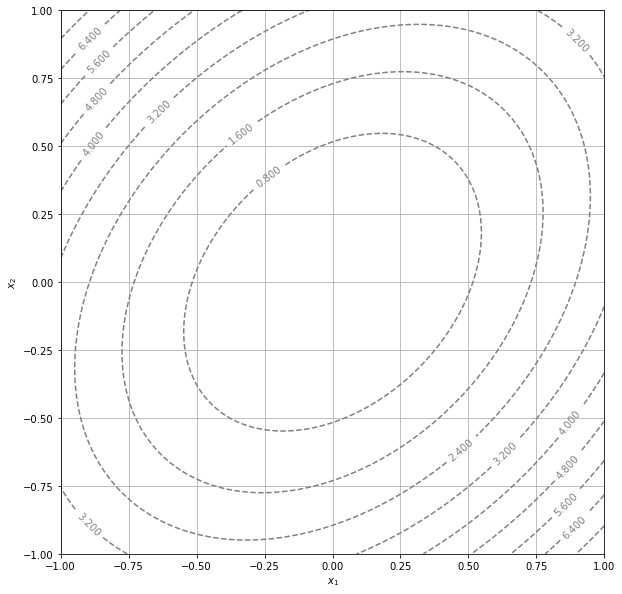

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

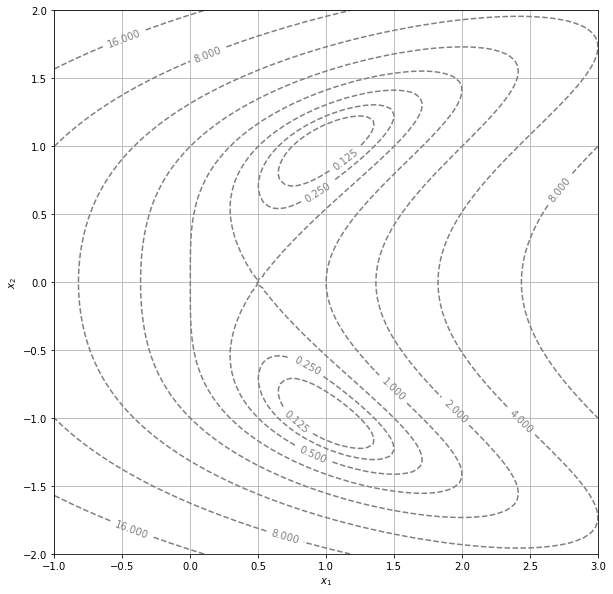

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

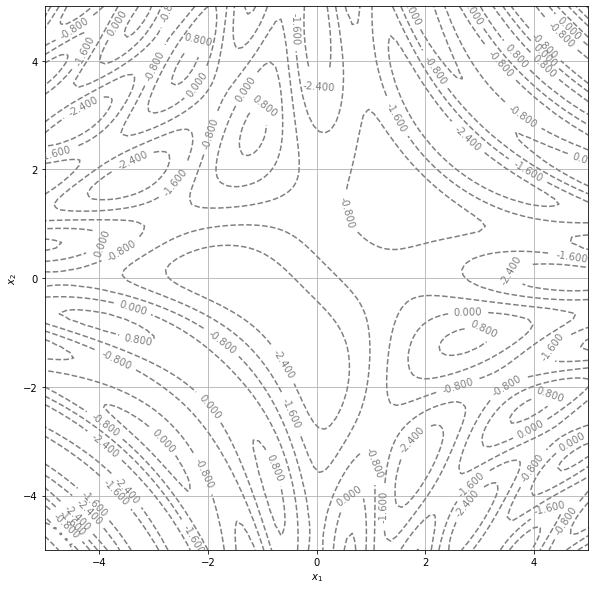

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?



Nous allons montrer que l'ensemble de niveau $c$ de $f$ est fermé et borné.

Preuve que cet ensemble est bornée :

Par l'absurde, on va supposer que l'ensemble de niveau c qui est $f^{-1}(\{c\})$ n'est pas borné. Comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, il existe $A\in \mathbb{R}$ tel que pour tout $(x_1,x_2)\in \mathbb{R}^2$ si $\|(x_1,x_2)\|>A$ alors $f(x_1,x_2)>c+1$. Donc $f^{-1}(\{c\})$ est majoré par A car de tels points ne sont pas dans l'ensemble de niveau ce qui est absurde car $f^{-1}(\{c\})$ n'est pas borné.

Donc $f^{-1}(\{c\})$ est borné.

Preuve que cet ensemble est un fermé :

L'ensemble de niveau c est $f^{-1}(\{c\})$. L'image réciproque d'un fermé par une fonction continue est un fermé donc c'est un fermé.

Conclusion :

L'ensemble de niveau c qui est $f^{-1}(\{c\})$ est un fermé borné. Comme nous somme en dimension finie, c'est un compacte.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

On remarque que : $p(x_1,x_2) = \frac{1}{\|\nabla f(x_0)\|}\left|\begin{array}((x_1 - x_{10})&{\partial_1 f(x_0)}\\(x_2 - x_{20})&{\partial_2 f(x_0)}\end{array}\right|$ . 

On peut interpréter le déterminant dans $\mathbb{R}^2$ comme l'aire orienté du paralélogramme formé par les deux vecteurs qui sont ici le gradient de f en x0 et un vecteur quelconque d'origine x0. 
Or ici On norme ici par la norme du gradient, ce serait alors plutôt le signe de $p(x_1,x_2)$ qui nous intéresse : il va donner la position relative entre un vecteur et le gradient. S'il est positif la base formé des deux vecteurs est direct dont le vecteur est à 'droite' du gradient, s'il est négatif à 'gauche' et si $p(x_1,x_2)=0$ les deux vecteurs sont colinéaires.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

On note $W$ le voisinage ouvert de $x_0$ et $U$ un autre ouvert. On va contruire une fonction $g: U \subset \mathbb{R}^2 \times \mathbb{R} \to \mathbb{R}^2$ qui est continuement différentiable et de sorte que $\partial_x g$ soit inversible dans le voisinage $W$.

On pose $g: (x_1,x_2,t) \to (f(x_1,x_2)-c,p(x_1,x_2)-t)$ . $g$ est bien continuement différentiable car ses coordonnées sont continuement différentiable car $f$ l'est et donc $p$ aussi.

On a de plus la matrice de  $\partial_x g = (df,dp)$ qui est $Jgx = \left(\begin{array}0\partial_1f&\partial_2 f\\\partial_1 p&\partial_2 p\end{array}\right) $ et $\det(Jgx) = \partial_1f*\partial_2 p - \partial_2 f*\partial_1 p = \frac{1}{\|\nabla f\|} (\partial_1f^2 + \partial_2 f^2) > 0$ donc $\partial_x g$ est inversible.

Ainsi d'après le théorème des fonctions implicites, comme $g(x_0,t_0)=0$, il existe un voisinage $]-\epsilon,\epsilon[$ de $t_0$ de sorte que $W\times]-\epsilon,\epsilon[ \subset U$ ainsi qu'une unique fonction $\gamma : ]-\epsilon,\epsilon[ \to \mathbb{R}$ continuement différentiable telle que pour tout $t\in]-\epsilon,\epsilon[$ et tout $x\in W$ :

$g(x,t)=0 \leftrightarrow x=\gamma (t)$ . On a alors aussi $p(x)=t$ par construction de g.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

D'après le théorème des fonctions implicites : $d\gamma(t) =-(\partial_x g (x,t))^{-1}.\partial_tg$

On a pour tout $(x,t)\in W\times]-\epsilon,\epsilon[ $ $\partial_tg(x,t)=(0,-1)$ qui est non nul.

D'autre part la matrice $Jgx$ de $\partial_x g (x,t)$ a pour inverse  $Jgx^{-1}  = \frac{1}{\partial_1 f\partial_2 p - \partial_2 f\partial_1 p}\left(\begin{array}0\partial_2p&-\partial_2 f\\-\partial_1 p&\partial_1 f\end{array}\right) $.

Donc : $J\gamma = \frac{1}{\frac{1}{\|\nabla f\|} (\partial_1f^2 + \partial_2 f^2)}\left(\begin{array}0\partial_2p&-\partial_2 f\\-\partial_1 p&\partial_1 f\end{array}\right)\left(\begin{array}00\\-1\end{array}\right)=\frac{1}{\|\nabla f\|}\left(\begin{array}0\partial_2f\\-\partial_1f\end{array}\right) $. La Jacobienne de $\gamma$ ne s'annulle pas sur $\left]-\varepsilon, \varepsilon \right[$ car le gradient de $f$ ne s'annule pas sur $W$.

Or $J\gamma.dt = \gamma dt$ dont pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ $\gamma'(t)$ est non nul.

De plus $<J\gamma,\nabla f>$ = 0 donc $\gamma'(t)$ est orthogonal à $\nabla f(\gamma(t))$.



## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.


On veut tracer des courbes de niveaux dont on sera de toute manière limité par la largeur de la ligne lors du tracé donc ça ne sert à rien d'avoir une grande précision car notre oeil ne fera pas de différence.

On choisit une valeur d'epsilon permettant une précision suffisante sur l'approximation voulue, mais qui ne nécéssite pas un nombre trop grand de tour de la fonction Newton afin de converger. On fait le choix de prendre $\epsilon = 10^{-5}$.


In [14]:
N = 100
eps = 10**(-5) 

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=10**(-3), N=100):

    def J_F(x,y):
        Jf = autograd.jacobian
        return(np.array([Jf(F,0)(x,y),Jf(F,1)(x,y)]).T)

    def inv_J_F(x,y):
        return(np.linalg.inv(J_F(x,y)))
    x=x0
    y=y0
    for i in range(N):
        # On calcul le produit de l'inverse de la jacobienne de F avec F en x,y.
        temp=(np.dot(inv_J_F(x,y),F(x,y)))
        # Pour calculer le prochain point on utilise la formule : (xk+1,yk+1) = (x,y) - JacobF(xk,yk)^(-1)*F(xk,yk)
        x = x - temp[0]
        y = y - temp[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y

    else:
        raise ValueError(f"no convergence in {N} steps.")



#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

Pour f(x,y)=1.6 et x=y on a à partir de (0.8,0.8) :  x= 0.632455576338555 y= 0.632455576338555
Pour f(x,y)=1.6 et x=y on a à partir de (0.5,0.6) :  x= 0.632455538357046 y= 0.632455538357046


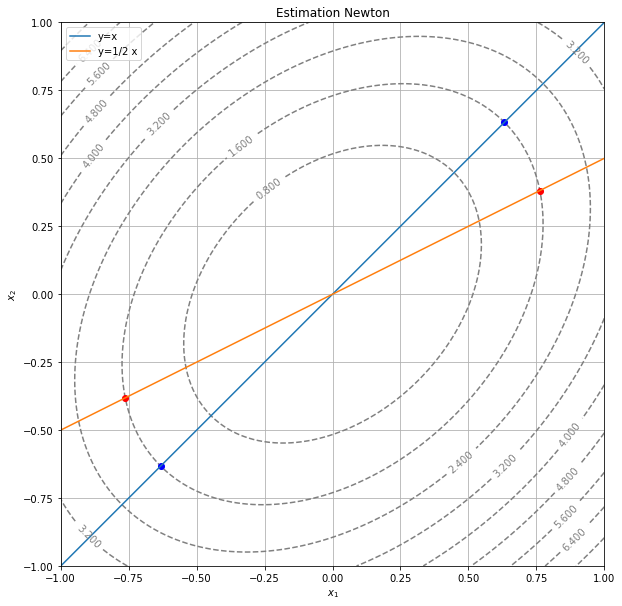

In [16]:
def rechercheniveau_equals(f,x0,y0,c): # On calcul ici le point d'intersection entre la courbe de niveau c et la doite x=y
    def F(x,y):
        return np.array([f(x,y)-c,x-y])
    x,y = Newton(F,x0,y0)
    return x,y

def rechercheniveau_equals2(f,x0,y0,c): # On calcul ici le point d'intersection entre la courbe de niveau c et la doite x=2y
    def F(x,y):
        return np.array([f(x,y)-c,x-2*y])
    x,y = Newton(F,x0,y0)
    return x,y

# Affichage des contours

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

# Affichage des points d'intersections

xi,yi = rechercheniveau_equals(f1,0.8,0.8,1.6)
pi,qi = rechercheniveau_equals(f1,0.5,0.6,1.6)  # Changement de conditions initiales 
ui,vi = rechercheniveau_equals2(f1,0.8,0.8,1.6) # Changement de contraintes
p,t = rechercheniveau_equals(f1,-0.8,-0.8,1.6)
h,f = rechercheniveau_equals2(f1,-0.5,-0.6,1.6)

print("Pour f(x,y)=1.6 et x=y on a à partir de (0.8,0.8) : ", "x=",xi,"y=",yi)
print("Pour f(x,y)=1.6 et x=y on a à partir de (0.5,0.6) : ", "x=",pi,"y=",qi)
plt.plot(xi,yi,'bo')
plt.plot(ui,vi,'bo',color='red')
plt.plot(p,t,'bo')
plt.plot(h,f,'bo',color='red')

L=np.linspace(-1,1,100) # Graph pour montrer l'intersection entre la courbe de niveau, y=x et y=1/2 x
plt.plot(L,L,label="y=x")
plt.plot(L,1/2*L,label="y=1/2 x")

plt.title("Estimation Newton")

plt.legend()
plt.show()
plt.show()

# On remarque que changer de conditions initiales ne change à priori rien, or comme on a deux points d'intersections entre la courbe de niveau c et la contrainte qui est ici une doite, on peut alors trouver l'autre solution.
# Changer de contrainte revient à changer la nature de l'intersection donc de points d'intersections.


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

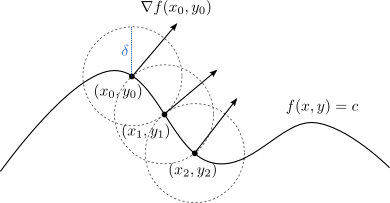

L'approche est la suivante : 
- On va contruire une fonction  $F: U \subset \mathbb{R}^2 \to \mathbb{R}^2$ tel que  $F: (x,y)  \to (f(x,y) - c, (x-x0)^2+(y-y0)^2-\delta^2)$ 
- On se ramène au problème d'intersection précédent en prenant comme contrainte le cercle de centre (x0,y0) et de rayon $\delta >0$.
- Pour pouvoir se placer à droite strictement du gradient, il va falloir initiliser la méthode de Newton à un point plus proche de la solution à droite du gradient que à gauche. On ne peut pas démarrer à (x0,y0) directement car il est à équidistance des deux solutions.
- Nous allons donc faire une rotation du gradient de $-\pi/2$ puis on le norme et on multiplie par $\delta$. On note V ce vecteur. On va alors considérer le point $(x1,y1) = (x0,y0) + V$ comme point de départ qui se trouve bien sur le cercle défini précédemment.
- La méthode de Newton va alors converger vers la bonne solution car on part sur l'arc de cercle à droite du gradient et la méthode va converger vers la solution la plus proche en terme de distance.



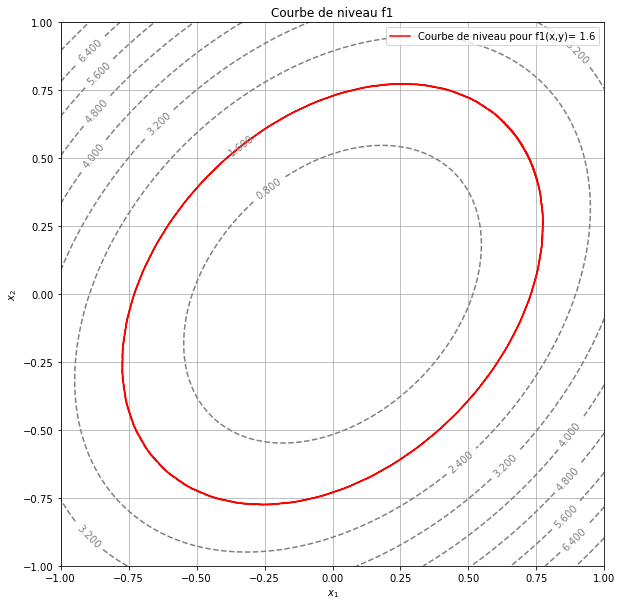

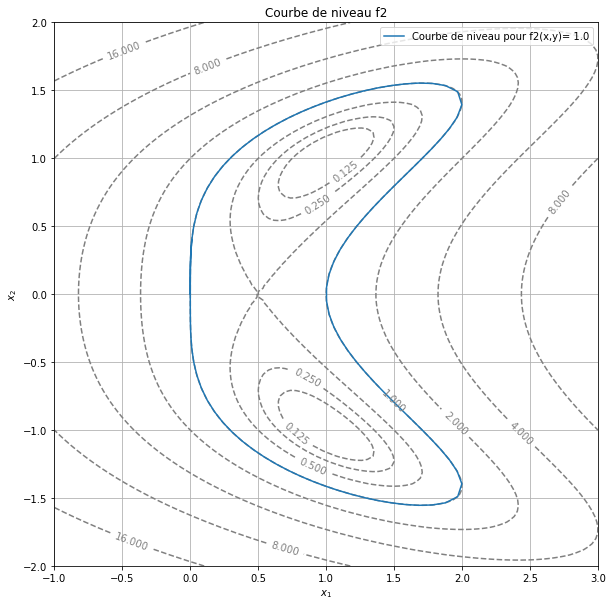

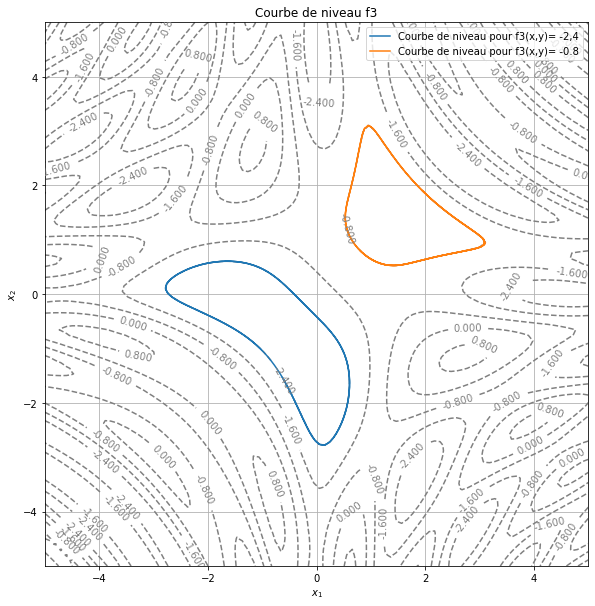

In [17]:
def level_curve(f, x0, y0,c, delta=0.1, N=100, eps=10**(-3)):
    """ Cette fonction prend en entrée une fonction f de R^2 dans R ainsi qu'un point de la courbe de niveau c et renvoie le prochain point à la distance delta à droite du gradient"""
    def gradf(x,y):
        gf= autograd.grad
        return np.array([gf(f,0)(x,y), gf(f,1)(x,y)])
    X=[x0]
    Y=[y0]
    x=x0
    y=y0

    # Construction de la courbe de niveau.

    for i in range(1,N):

        # On effectue la rotation et on adapte la norme.

        A=np.array([gradf(x,y)[1],-gradf(x,y)[0]])
        A=A/np.linalg.norm(A)
        def F(x1, x2):
            return np.array([f(x1,x2)-c,(x1-X[-1])**2 + (x2-Y[-1])**2 - delta**2])

        # On défini le point de départ pour la méthode de Newton.

        x=x+delta*A[0]
        y=y+delta*A[1]

        # implémentation de Newton

        temp = Newton(F,x,y,eps)

        x=temp[0]
        y=temp[1]
        X.append(x)
        Y.append(y)
    return(np.array([X,Y]))


# Affichage des résultats

#Courbe de niveau pour f1 :

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
a,b=rechercheniveau_equals(f1,0.8,0.8,1.6)
T= level_curve(f1,a,b,1.6)
plt.plot(T[0],T[1],color='red',label='Courbe de niveau pour f1(x,y)= 1.6')
plt.title("Courbe de niveau f1")
plt.legend()
plt.show()
plt.close()

#Courbe de niveau pour f2 :

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
u,v=rechercheniveau_equals(f2,0.8,0.8,1)
T2=level_curve(f2,u,v,1)
plt.plot(T2[0],T2[1],label='Courbe de niveau pour f2(x,y)= 1.0')
k,l=rechercheniveau_equals(f2,0.8,0.8,0.5)
plt.title("Courbe de niveau f2")
plt.legend()
plt.show()
plt.close()

#Courbe de niveau pour f3 :

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
i,j=rechercheniveau_equals(f3,0.8,0.8,-2.4)
m,n=rechercheniveau_equals(f3,0.8,0.8,-0.8)
T3=level_curve(f3,i,j,-2.4,N=200) 
T4=level_curve(f3,m,n,-0.8,N=200)
plt.plot(T3[0],T3[1],label='Courbe de niveau pour f3(x,y)= -2,4')
plt.plot(T4[0],T4[1],label='Courbe de niveau pour f3(x,y)= -0.8')
plt.title("Courbe de niveau f3")
plt.legend()
plt.show()
   

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

On commence par coder une fonction qui renvoie True si deux segments s'intersectent et False sinon. Ensuite dans level_curve, il suffit de mettre dans une boucle while la condition : état de l'intersection entre le premier et le dernier segment.  

On peut en effet se limiter à l'intersection avec le premier segment puisque le seul cas ou cela pose problème est celui des courbes auto-intersectantes : le programme fera converger les points au point de gradient nul. Le premier et dernier segment peuvent alors ne jamais se rencontrer. De plus, les courbes auto-intersectantes nécéssite d'avoir 3 annulations de gradient dans un même voisinage. Finalement, les intersections ne se situe que sur une des courbes de niveau, il faut donc être assez malchanceux pour que ça arrive.    

Cependant, dans le cas ou on à une courbe auto sécante, la boucle while a de forte chance de ne jamais se terminer. C'est pourquoi on implémente un "limiteur" qui décide au bout de 1000 points de terminer le programme.
La méthode présentée dans ce devoir n'est donc pas adaptée pour les courbes auto-intersectantes.


In [18]:
def Intersect(P1,P2,P3,P4):

    if (max(P1[0],P2[0]) < min(P3[0],P4[0])): # Pas d'intersection possible car intervalles disjoints.
        return False

    if P1[0]-P2[0] != 0 and P3[0]-P4[0] !=0 :
        A1 = (P1[1]-P2[1])/(P1[0]-P2[0])  # y = ax+b
        A2 = (P3[1]-P4[1])/(P3[0]-P4[0])
        b1 = P1[1]-A1*P1[0]
        b2 = P3[1]-A2*P3[0]
        if A1==A2 : # Segments parrallèles
            return(False)
        else : 
            Xa = (b2 - b1) / (A1 - A2) ## abscisse de l'intersection
            if ( (Xa < max( min(P1[0],P2[0]), min(P3[0],P4[0]) )) or (Xa > min( max(P1[0],P2[0]), max(P3[0],P4[0]) )) ):
                return False #L'abscisse de l'intersection doit être dans le domaine de définition des segments
            else : 
                return True


# autre implémentation.

def Intersect2(P1,P2,P3,P4):
    # On cherche le point d'intersection avec une représentation cartésienne d'une droite et paramétrique d'une autre. Puis on regarde si ce point est bien sur les segments.

    # On sépare le cas où on a des droites verticales
    
    if (P1[0]-P2[0]==0 or P3[0]-P4[0]==0):
        if (P1[0]-P2[0]==0 and P3[0]-P4[0]==0):
            return False
        else :
            if P1[0]-P2[0]==0 : # on a x = c
                X = P1[0]
                Y =  (P3[1]-P4[1])/(P3[0]-P4[0])*P1[0] + P3[1]-A2*P3[0]
            else :
                X = P3[0]
                Y = (P1[1]-P2[1])/(P1[0]-P2[0])*P3[0]+ P1[1]-A1*P1[0]
    else :

        
        A1 = (P1[1]-P2[1])/(P1[0]-P2[0])  # y = ax+b
        A2 = (P3[1]-P4[1])/(P3[0]-P4[0])
        b1 = P1[1]-A1*P1[0]
        if A1==A2 : # Segments parrallèles
                return(False)
        else : 
            t = (-A1*P3[0]+P3[1]-b1)/(A1-A2)
            X = P3[0] + t
            Y = P3[1] + t*A2
    if (min(P1[0],P2[0])<= X<= max(P1[0],P2[0]) and min(P3[0],P4[0])<= X<= max(P3[0],P4[0])) and (min(P1[1],P2[1])<= Y<= max(P1[0],P2[0]) and min(P3[1],P4[1])<= Y<= max(P3[1],P4[1])):
        return True
    else :
        return False

def level_curve_bis(f, x0, y0,contrainte, delta=0.1, N=100, eps=10**(-3)):
    def gradf(x,y):
        gf= autograd.grad
        return np.array([gf(f,0)(x,y), gf(f,1)(x,y)])
    X=[x0]
    Y=[y0]
    x=x0
    y=y0
    a=True
    Limit=0 # Pour éviter d'avoir une boucle infinie, commme dans le cas de des courbes de niveau auto sécantes
    while (a):
        A=np.array([gradf(x,y)[1],-gradf(x,y)[0]])
        A=A/np.linalg.norm(A)
        def F(x1, x2):
            return np.array([f(x1,x2)-contrainte,(x1-X[-1])**2 + (x2-Y[-1])**2 - delta**2])
        x=x+delta*A[0]
        y=y+delta*A[1]
        temp=Newton(F,x,y)
        x=temp[0]
        y=temp[1]
        X.append(x)
        Y.append(y)
        if len(X)>3 : # s'arrete au bout d'un tour sinon (point en commun)
            a=not (Intersect([x,y],[X[-2],Y[-2]],[X[1],Y[1]],[x0,y0]))
        Limit=Limit+1
        if Limit > 1000 :
            break
    return(np.array([X,Y]))

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

Pour f1 on a :
Nombre de point par la méthode classique :  100
Nombre de point par la méthode des segments :  50


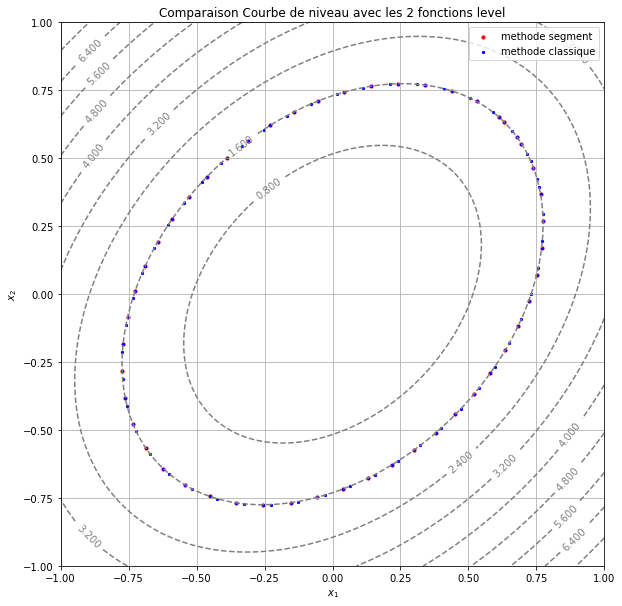

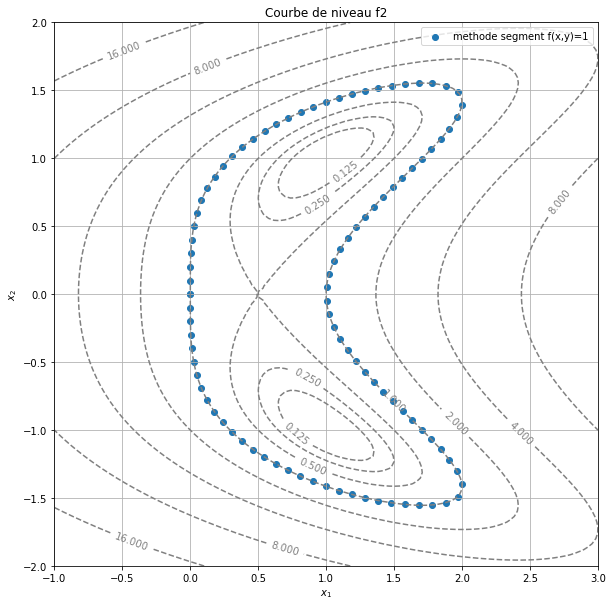

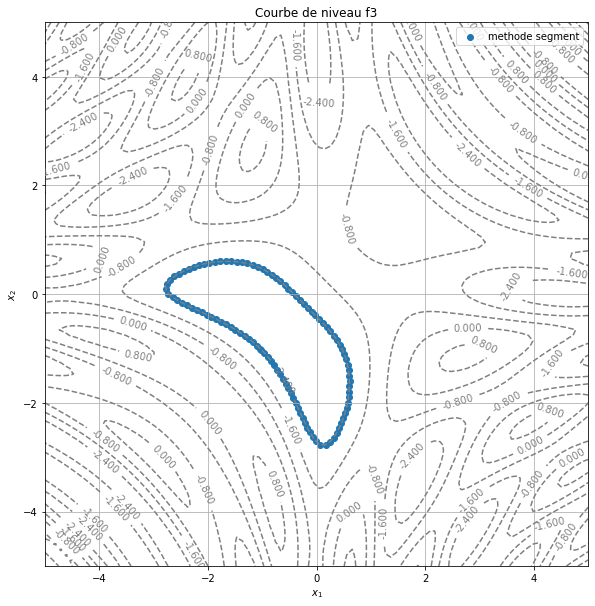

In [19]:
#Courbe de niveau pour f1 :
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
a,b=rechercheniveau_equals(f1,0.8,0.8,1.6)
Tbis=level_curve_bis(f1,a,b,1.6)
T=level_curve(f1,a,b,1.6)
print("Pour f1 on a :")
print("Nombre de point par la méthode classique : ", len(T[0]))
print("Nombre de point par la méthode des segments : ",len(Tbis[0])) # On remarque bien que le nb de points est inférieur sur Tbis !!
plt.scatter(Tbis[0],Tbis[1],color='red',label = 'methode segment',s=10)
plt.scatter(T[0],T[1],label='methode classique',color='blue',s=5)
plt.title("Comparaison Courbe de niveau avec les 2 fonctions level")
plt.legend()
plt.show()

#Courbe de niveau pour f2 :

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
u,v=rechercheniveau_equals(f2,0.8,0.8,1)
T2=level_curve_bis(f2,u,v,1)
plt.scatter(T2[0],T2[1],label='methode segment f(x,y)=1')
plt.title("Courbe de niveau f2")
plt.legend()
plt.show()

#Courbe de niveau pour f3 :

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
i,j=rechercheniveau_equals(f3,0.8,0.8,-2.4)
T3=level_curve_bis(f3,i,j,-2.4)
plt.scatter(T3[0],T3[1],label = 'methode segment')
plt.title("Courbe de niveau f3")
plt.legend()
plt.show()
   



## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

On cherche à déterminer les coefficients $a, b, c, d, e, f$ solutions du problèmes et les expliciter en fonction de $P_1$, $P_2$, $u_1$ et $u_2$.

On note leur coordonnées: 
$P_1 = (x_{p1}, y_{p1})$ ;
$P_2 = (x_{p2}, y_{p2})$ ;
$u_1 = (x_{u1}, y_{u2})$ ;
$u_2 = (x_{u2}, y_{u2})$ 


On a les conditions aux limites : $\gamma(0) = P_1 \Leftrightarrow 
\left\{\begin{matrix}
a=x_{p1}\\ 
d=y_{p1}
\end{matrix}\right.$

et $\gamma(1) = P_2 \Leftrightarrow \left\{\begin{matrix}
a+b+c=x_{p2}\\ 
d+e+f=y_{p2}
\end{matrix}\right.  (1)$

De plus on sait que   $\gamma'(0)$  est dans la même direction et le même sens que  $u_1$  et  $\gamma'(1)$  soit dans la même direction et le même sens que  $u_2$, c'est-à-dire qu'il existe
$\alpha$ et $\beta$ des réels positifs tels que: $\left\{\begin{matrix}
\gamma'(0)=\alpha u_1\\ 
\gamma'(1)=\beta u_2
\end{matrix}\right.$
$\Leftrightarrow \left\{\begin{matrix}
b=\alpha x_{u1}\\ 
e=\alpha y_{u1}\\
b + 2c = \beta x_{u2}\\
e +2f = \beta y_{u2}
\end{matrix}\right.$ $\Leftrightarrow \left\{\begin{matrix}
b=\alpha x_{u1}\\ 
e=\alpha y_{u1}\\
\alpha x_{u1} + 2c = \beta x_{u2}\\
\alpha y_{u1} +2f = \beta y_{u2}
\end{matrix}\right.  (2)$


$ (1)\Leftrightarrow \left\{\begin{matrix}
c= x_{P2}-x_{P1}-\alpha x_{u1}\\ 
f= y_{P2}-y_{P1}-\alpha y_{u1}
\end{matrix}\right. $

On injecte dans les deux dernière equation de $(2)$ et on obtient :

$\left\{\begin{matrix}
\alpha x_{u1} + 2x_{P2}-2x_{P1}-2\alpha x_{P1} = \beta x_{u2}\\ 
\alpha y_{u1} +2y_{P2}-2y_{P1}-2\alpha y_{P1} = \beta y_{u2}
\end{matrix}\right.$
$\\
\Leftrightarrow \left\{\begin{matrix}
2x_{P2}-2x_{P1}-\alpha x_{P1} = \beta x_{u2}\\ 
2y_{P2}-2y_{P1}-\alpha y_{P1} = \beta y_{u2}
\end{matrix}\right.$
$\\
\Leftrightarrow \left\{\begin{matrix}
\alpha x_{u1} + \beta x_{u2} = 2(x_{P2}-x_{P1})\\ 
\alpha y_{u1} + \beta y_{u2} = 2(y_{P2}-y_{P1})
\end{matrix}\right.$

Pour que ce système est une solution, il faut que le déterminant de la matrice $ \begin{pmatrix}
x_{u1} & x_{u2}\\ 
y_{u1} & y_{u2}
\end{pmatrix}$ soit non nul, c'est-à-dire :

$ \left | \begin{pmatrix}
x_{u1} & x_{u2}\\ 
y_{u1} & y_{u2}
\end{pmatrix} \right | = x_{u1}y_{u2}- x_{u2}y_{u1} \neq 0 $, ce qui revient à dire $u_1$ et $u_2$ non colinéaires.

Dans ce cas-là, on résout le système et on trouve comme forme de solution :

$\alpha = 2 \frac{\left | \begin{pmatrix}
x_{P2}-x_{P1} & x_{u2}\\ 
y_{P2}-y_{P1} & y_{u2}
\end{pmatrix} \right |}{det(u1,u2}=2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} $ et 
$
\beta = 2 \frac{\left | \begin{pmatrix}
 x_{u1} &x_{P2}-x_{P1}\\ 
 y_{u1} &y_{P2}-y_{P1}
\end{pmatrix} \right |}{det(u1,u2}=2 \frac{x_{u1}(y_{P2}-y_{P1})-y_{u1}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}}$

On peut alors résoudre en remplaçant dans les différentes équations et on obtient : 

$\left\{\begin{matrix}
a=x_{p1}\\ 
b=\alpha x_{u1} \\
c=\frac{\beta x_{u2} - \alpha x_{u1}}{2} \\
d=y_{p1}\\
e=\alpha y_{u1} \\
f =\frac{\beta y_{u2} - \alpha y_{u1}}{2} \\
\end{matrix}\right.$

Donc : 

$\left\{\begin{matrix}
a=x_{p1}\\ 
b=2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} x_{u1} \\
c=\frac{2 \frac{x_{u1}(y_{P2}-y_{P1})-y_{u1}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} x_{u2} - 2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} x_{u1}}{2} \\
d=y_{p1}\\
e=2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} y_{u1} \\
f =\frac{2 \frac{x_{u1}(y_{P2}-y_{P1})-y_{u1}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} y_{u2} - 2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{P1}y_{P2}- x_{P2}y_{P1}} y_{u1}}{2} \\
\end{matrix}\right.$



#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [20]:
#recopier la solution du systeme

In [24]:
def chemin(A,B,U,V) : #Systeme à 6 équations AX = Y; 6 inconnus X=(abcdef) Y=(P2[0],P2[1],P1[0],P1[1],0,0) 
                        
    Mat = np.zeros((6,6))
    for i in range(3):
        Mat[2,i]=1
        Mat[3,3+i]=1
    Mat[0,0]=1
    Mat[1,3]=1
    Mat[4,1]=U[1]
    Mat[4,4]=-U[0]
    Mat[5,1]=V[1]
    Mat[5,2]=2*V[1]
    Mat[5,4]=-V[0]
    Mat[5,5]=-2*V[0]
    if (np.linalg.det(Mat)) !=0 : #Si la matrice est inversible
        Y=np.array([A[0],A[1],B[0],B[1],0,0]) # On fait ça avec le produit vectoriel, ce qui ne donne que la direction
                                                # mais par unicité de la solution matricielle, on peut tester apres coup 
                                                #avoir le bon sens
        X = np.linalg.solve(Mat,Y)

        N=np.array([X[1],X[4]])
        U=np.array(U)
        K = np.vdot(N,U)- np.linalg.norm(U)*np.linalg.norm(N)
        V=np.array(V)
        M=np.array([X[1]+2*X[2],X[4]+2*X[5]])
        J = (np.vdot(M,V) - np.linalg.norm(V)*np.linalg.norm(M))
        if (( abs(K) < 10**(-3) ) and (abs(J) < 10**(-3))):
            return (X)
        else : 
            return([])
    else : 
        return([])

def gamma(t,P1,P2,u1,u2) :
    X = chemin(P1,P2,u1,u2)
    t=np.array([t])
    if len(X) == 0 : # Approximation linéaire 
        A=(P2[1]-P1[1])/(P2[0]-P1[0])
        return(np.array([P1[0] + t*(P2[0]-P1[0]),P1[1]+ t*A*(P2[0]-P1[0])]))
    else : 
        return (np.array([X[0]+X[1]*t+X[2]*t**2,X[3]+X[4]*t+X[5]*t**2]))


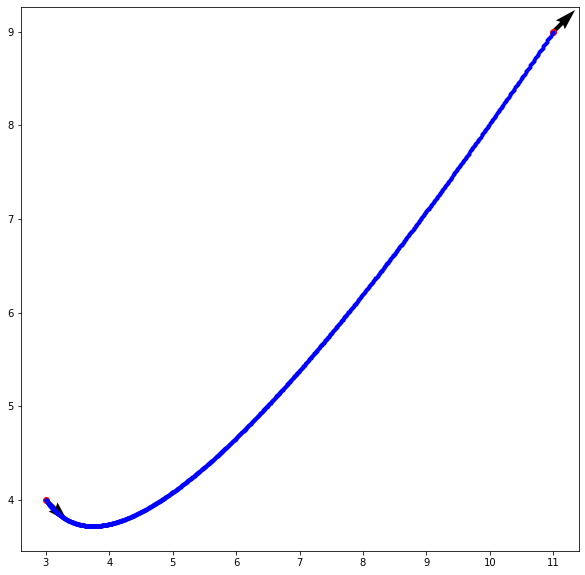

In [25]:
#representation graphique :
#On test avec 2 points, 2 vecteurs : 
P1=[3,4]
P2=[11,9]
u1=[1,-1]
u2=[1,1]

T=np.linspace(0,1,1000)
Y=gamma(T,P1,P2,u1,u2)
#On plot les points 
plt.plot(P1[0],P1[1],color = 'red',marker='o')
plt.plot(P2[0],P2[1],color = 'red',marker='o')


plt.plot(Y[0],Y[1],marker='.',color='blue')

#On plot les vecteurs : 
plt.quiver(P1[0],P1[1],u1[0],u1[1])
plt.quiver(P2[0],P2[1],u2[0],u2[1])

plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [23]:
def level_curve_interp(f, x0, y0,contrainte,oversampling, delta=0.1, N=100, eps=10**(-3)):
    def gradf(x,y):
        gf= autograd.grad
        return np.array([gf(f,0)(x,y), gf(f,1)(x,y)])
    X=[x0]
    Y=[y0]
    x=x0
    y=y0
    a=True
    Limit=0
    while (a):
        A=np.array([gradf(x,y)[1],-gradf(x,y)[0]])
        A=A/np.linalg.norm(A)
        def F(x1, x2):
            return np.array([f(x1,x2)-contrainte,(x1-X[-1])**2 + (x2-Y[-1])**2 - delta**2])
        x=x+delta*A[0]
        y=y+delta*A[1]
        x=Newton(F,x,y)[0]
        y=Newton(F,x,y)[1]
        X.append(x)
        Y.append(y)
        if len(X)>3 : ## Pb au début, s'arrete au bout d'un tour sinon (point en commun)
            a=not (Intersect([x,y],[X[-2],Y[-2]],[X[1],Y[1]],[x0,y0]))
        Limit = Limit +1
        if Limit>1000:
            break
    if oversampling <=1 :
        return(np.array([X,Y]))
    else :
        D=[X[0]]
        F=[Y[0]]
        N=math.floor(oversampling-1)
        L=np.linspace(1/N,1-1/N,N)
        for i in range(1,len(X)-2):
            U=[X[i]-X[i-1],Y[i]-Y[i-1]]
            V=[X[i+2]-X[i+1],Y[i+2]-Y[i+1]]
            T=gamma(L,[X[i],Y[i]],[X[i+1],Y[i+1]],U,V)
            D.append(X[i])
            F.append(Y[i])
            for j in range(0,len(T[0,0])):
                D.append(T[0,0,j])
                F.append(T[1,0,j])
        D.append(X[-2])
        F.append(Y[-2])
        D.append(X[-1])
        F.append(Y[-1])
        return(np.array([D,F]))

SyntaxError: 'break' outside loop (<ipython-input-23-d6fa3675a1fd>, line 26)

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

In [ ]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
a,b=rechercheniveau_equals(f1,0.8,0.8,1.6)
Tinterp=level_curve_interp(f1,a,b,1.6,5)
Tbis=level_curve_bis(f1,a,b,1.6)
plt.scatter(Tbis[0],Tbis[1],color='blue',s=20)
plt.scatter(Tinterp[0],Tinterp[1],color='red',s=5)
plt.show()